<a href="https://colab.research.google.com/github/bragarods/rainfall_forecast/blob/master/notebooks/colab_ts_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

plt.rcParams['figure.figsize'] = (13, 7)

In [2]:
!pip3 install --upgrade tslearn
!pip install --upgrade chart_studio
clear_output()

## Import monthly data

In [4]:
# google drive shareable file link

orig_url = 'https://drive.google.com/file/d/1WQ9NARYCNZxWlQUAf4Zn5TxJcnOGjEn3/view?usp=sharing'

# get file id

file_id = orig_url.split('/')[-2]

# create download url

dwn_url='https://drive.google.com/uc?export=download&id=' + file_id

# get raw text inside url

url = requests.get(dwn_url).text

# create a buffer

csv_raw = StringIO(url)

# read from buffer

df = pd.read_csv(csv_raw, index_col=0)

df.reset_index(drop=True, inplace=True)

# create sinop and csinop series

df['date'] = pd.to_datetime(df['date'], format=('%Y-%m-%d')) 

#df.set_index('date', inplace=True)

# cut train period

train = df[(df.date >= '2000-01-01') & (df.date <= '2019-12-01')]

test = df[df.date >= '2019-01-01']

## Flag first full year of data

In [5]:
df['chuva_max_12m'] = df.groupby('cd_estacao')['chuva'].rolling(12).max().reset_index(0,drop=True)

df['flag_chuva_max_12m'] = np.where((~df['chuva_max_12m'].isna()) & (df['chuva_max_12m'] >= 1),
                               1,
                               0)

min_year = df[df['flag_chuva_max_12m']==1].groupby('cd_estacao').agg(min_year=('date','min'))['min_year'].dt.year+1

df = pd.merge(df,min_year,how='left',left_on=df.cd_estacao,right_on=min_year.index)

df.drop(columns='key_0', inplace=True)

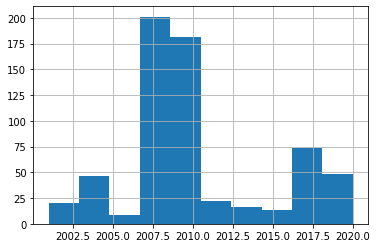

In [ ]:
df.drop_duplicates(['cd_estacao']).min_year.hist()

# most of the stations has data avaiable from 2009

## Clustering series

In [6]:
df2009 = df[(df['min_year']<=2009) & (df.date >= '2009-01-01')]

In [7]:
dfp = df2009.set_index('date').pivot(columns=['cd_estacao'], values=['chuva'])
dfp.columns = dfp.columns.droplevel()

In [8]:
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw
from tslearn.utils import to_time_series_dataset


# define seed
seed = 0
np.random.seed(seed)

X, y = dfp[dfp.index<='2018-12-01'], dfp[dfp.index > '2018-12-01']

series = []

for col in dfp.columns:
  series.append(dfp[col])

X_train = to_time_series_dataset([s.values for s in series])

X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

#X_train = X_train[y_train < 4]  # Keep first 3 classes
#numpy.random.shuffle(X_train)
# Keep only 50 time series
#X_train = TimeSeriesScalerMeanVariance().fit_transform(X)
# Make time series shorter
#X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
#sz = X_train.shape[1]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


Euclidean k-means
136.139 --> 84.408 --> 83.676 --> 83.499 --> 83.472 --> 83.472 --> 
Cluster 1 7.614876018699265
Cluster 2 8.595082837680993
Cluster 3 7.515132383859045
Cluster 4 7.513771158276948
Cluster 5 6.801258369574671


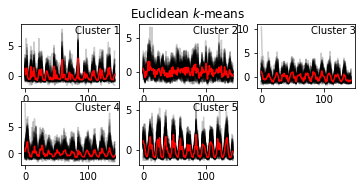

In [16]:
# Euclidean k-means
print("Euclidean k-means")
n_clusters = 5
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure()
for yi in range(n_clusters):
    plt.subplot(round(n_clusters/3)+1, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, X_train.shape[1])
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")



In [73]:
## Optimizer -- Euclidean k-means

print("Euclidean k-means")

ds = pd.DataFrame([])

for n_clusters in np.arange(2, int(X_train.shape[0]/2), 10):

  print('Running w/ n_clusters = {}...'.format(n_clusters))
  
  km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
  y_pred = km.fit_predict(X_train)

  cdist = []

  for yi in np.arange(0,n_clusters):
    cdistm = cdist_dtw(X_train[y_pred==yi]).mean()
    cdist.append(cdistm)

  ds1 = pd.DataFrame(cdist).describe().T

  ds1['points'] = [cdist]

  ds = ds.append(ds1)

Euclidean k-means
Running w/ n_clusters = 2...
181.972 --> 104.506 --> 103.632 --> 103.510 --> 103.372 --> 103.066 --> 102.660 --> 102.212 --> 101.475 --> 100.936 --> 100.612 --> 100.544 --> 100.524 --> 100.515 --> 100.515 --> 
Running w/ n_clusters = 12...
117.711 --> 75.229 --> 73.566 --> 72.795 --> 72.561 --> 72.499 --> 72.495 --> 72.487 --> 72.487 --> 
Running w/ n_clusters = 22...
100.673 --> 69.371 --> 66.508 --> 66.055 --> 65.698 --> 65.471 --> 65.356 --> 65.306 --> 65.282 --> 65.282 --> 
Running w/ n_clusters = 32...
94.950 --> 64.176 --> 61.834 --> 61.369 --> 61.117 --> 60.929 --> 60.856 --> 60.819 --> 60.810 --> 60.810 --> 
Running w/ n_clusters = 42...
90.112 --> 60.152 --> 58.274 --> 57.925 --> 57.679 --> 57.457 --> 57.248 --> 57.157 --> 57.135 --> 57.126 --> 57.117 --> 57.117 --> 
Running w/ n_clusters = 52...
85.176 --> 57.168 --> 55.347 --> 54.861 --> 54.602 --> 54.426 --> 54.330 --> 54.330 --> 
Running w/ n_clusters = 62...
80.615 --> 53.787 --> 52.054 --> 51.743 --> 51

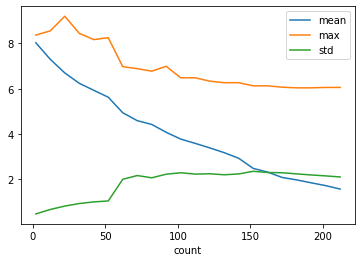

In [75]:
ds.set_index('count')[['mean','max', 'std']].plot()

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


584076.669 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


432425.049 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


427137.690 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


424229.270 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


424229.270 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.6s finished


555325.730 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


428975.991 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


428975.991 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


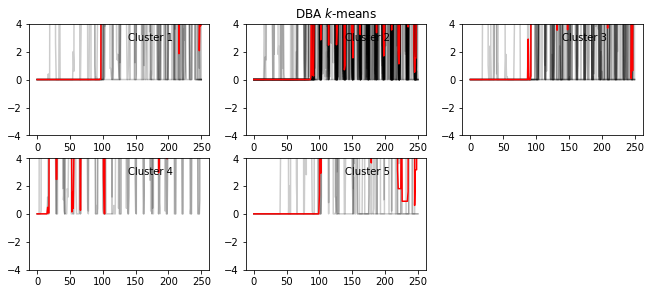

In [ ]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(5):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

Soft-DTW k-means
402107476144.291 --> 228845262320.792 --> 228715719321.222 --> 228614919395.713 --> 228405432541.201 --> 228337463072.049 --> 228178757251.933 --> 228134774892.517 --> 227997181964.666 --> 227963382314.981 --> 227580728441.034 --> 227529437484.235 --> 227493905221.291 --> 227381302478.524 --> 227358674047.171 --> 227291078729.013 --> 227274284559.461 --> 227262282613.917 --> 227252902720.132 --> 227224359845.215 --> 227203365063.163 --> 227123492886.753 --> 227111311054.270 --> 226961959062.693 --> 226939177437.379 --> 226933052357.031 --> 226930021880.422 --> 226928433326.911 --> 226928496757.061 --> 226930005243.465 --> 226933113856.871 --> 226937558170.403 --> 226944875381.419 --> 226943436484.111 --> 226955086761.506 --> 226952331524.125 --> 226954354803.571 --> 226952203159.306 --> 226957614857.439 --> 226955744515.323 --> 226980417392.938 --> 226974464611.521 --> 226979894528.999 --> 226980471535.747 --> 226983186752.057 --> 226983454977.074 --> 226980525913.987 

ValueError: ignored

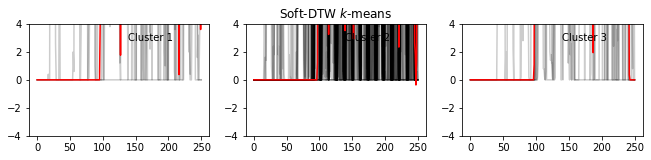

In [ ]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(5):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()

In [9]:
## Optimizer -- Soft-DTW-k-means

print("Soft-DTW k-means")

seed = 0

dss = pd.DataFrame([])

for n_clusters in np.arange(2, int(X_train.shape[0]/2), 50):

  print('Running w/ n_clusters = {}...'.format(n_clusters))
  
  sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           n_jobs=-1,
                           random_state=seed)
  y_pred = sdtw_km.fit_predict(X_train)

  cdist = []

  for yi in np.arange(0,n_clusters):
    cdistm = cdist_dtw(X_train[y_pred==yi]).mean()
    cdist.append(cdistm)

  ds1 = pd.DataFrame(cdist).describe().T

  ds1['points'] = [cdist]

  dss = dss.append(ds1)

  print(dss)

Soft-DTW k-means
Running w/ n_clusters = 2...
3886.718 --> 1690.892 --> 1676.731 --> 1671.552 --> 1670.693 --> 1669.337 --> 1668.850 --> 1666.809 --> 1665.130 --> 1663.754 --> 1664.190 --> 1661.251 --> 1658.560 --> 1658.501 --> 1659.142 --> 1657.258 --> 1656.937 --> 1656.482 --> 1656.153 --> 1655.763 --> 1655.320 --> 1654.619 --> 1654.095 --> 1653.616 --> 1653.009 --> 1652.705 --> 1652.173 --> 1651.610 --> 1651.506 --> 1651.759 --> 1651.372 --> 1650.310 --> 1649.790 --> 1649.456 --> 1649.105 --> 1648.814 --> 1648.568 --> 1648.191 --> 1647.855 --> 1647.736 --> 1647.512 --> 1646.505 --> 1646.116 --> 1645.981 --> 1645.838 --> 1645.864 --> 1645.855 --> 1645.759 --> 1645.705 --> 1645.692 --> 
   count      mean  ...       max                                  points
0    2.0  7.971084  ...  8.174774  [8.174773640368672, 7.767394251358512]

[1 rows x 9 columns]
Running w/ n_clusters = 52...
1249.151 --> 653.949 --> 648.204 --> 646.831 --> 646.533 --> 646.058 --> 645.813 --> 645.709 --> 645.65

KeyboardInterrupt: ignored

## Plotting

In [ ]:
from tslearn.utils import to_time_series_dataset, to_pyts_dataset

fdf = pd.DataFrame(to_pyts_dataset(X_train))

fdf = fdf.set_index([df2009.drop_duplicates('cd_estacao').cd_estacao, y_pred]).sort_index()

In [ ]:
kndf = pd.DataFrame(fdf.index.to_list(), columns=['cd_estacao','kcluster'])

kndf1 = pd.merge(kndf, df2009[['cd_estacao','dc_nome','vl_latitude','vl_longitude']], how='left',left_on='cd_estacao',right_on='cd_estacao')

In [ ]:
kndf2 = kndf1.drop_duplicates('cd_estacao').reset_index(drop=True)

In [ ]:
kndf2.head()

,cd_estacao,kcluster,dc_nome,vl_latitude,vl_longitude
0,A001,15,brasilia,-15.789343,-47.925756
1,A002,15,goiania,-16.642841,-49.220222
2,A003,15,morrinhos,-17.745066,-49.101698
3,A004,3,niquelandia,-14.469358,-48.485756
4,A005,4,porangatu,-13.309528,-49.117478


## Data on Map

In [ ]:
import chart_studio.plotly as py
from plotly.offline import iplot
import plotly.graph_objs as go
import pandas as pd

# Change API key for Plotly 

#tl.set_credentials_file(username='aschrock', api_key='CWwy1WgujKrPK4Z1J0Oh')

# Add Mapbox access token here 

mapbox_access_token = 'pk.eyJ1IjoiYXNjaHJvY2siLCJhIjoiY2p2NnRoeHc2MDkxbTQ0bnR6aTVwZDNsaCJ9.MA76hkxD3rOGgnVCDBVC9w'

#df = pd.read_csv('http://geohub.lacity.org/datasets/259473fbb4b34ff182581f411fe4c918_49.csv')

# Save latitude and longitude as variables. In this dataset, the X column is longitude and the Y column is latitude. 

site_lat = df2009.drop_duplicates('dc_nome').vl_latitude
site_lon = df2009.drop_duplicates('dc_nome').vl_longitude
locations_name = df2009.drop_duplicates('dc_nome').dc_nome

name = 'Estações Inmet - #{}'.format(len(df2009.drop_duplicates('dc_nome').dc_nome))

# Generate the data for the map 

data = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=7,
            color='rgb(255, 0, 0)',
            opacity=1
        )
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=13,
            color='rgb(242, 177, 172)',
            opacity=0.8
        ),
        text=locations_name,
        hoverinfo='text'
    )]


# Generate a layout around Los Angeles, zoomed in so we can see the data points 

layout = go.Layout(
    title=name,
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=-15.789343,
            lon=-47.925756
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)
	
# Generate the figure using the iplot function 
  
fig = dict(data=data, layout=layout)
iplot(fig, filename=name)